# Time Series Processing

In [11]:
import os
import pandas as pd
from fastdtw import fastdtw
from statistics import mean, pstdev
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.distance import euclidean
import pygal
import seaborn as sns
import shutil


In [2]:
def get_subdirectories(directory=""):
    subdirectories = []
    p = Path("./../experiments_data/" + directory)
    for item in p.glob('*/'):
        if item.suffix not in (['.csv', '.zip']):
            subdirectories.append(directory + "/" + item.name)
    return subdirectories

In [3]:
all_directories = get_subdirectories()
nodes_directories = [x for x in all_directories if "node" in x]

data_directories = []
data_directories_groups = []
for directory in nodes_directories:
    cur_node_subdirectories = get_subdirectories(directory)
    data_directories.append(cur_node_subdirectories)

data_directories_groups = data_directories
data_directories = [item for sublist in data_directories for item in sublist]

function_names = data_directories_groups[1]
function_names = list(map(lambda x: x[8:], data_directories_groups[1]))

### All functions in `experiments_data`

In [4]:
for function in function_names:
    print(f"- {function[1:]}")

- avgNetProfitGroupedBySoldDate
- avgNetProfitGroupedBySoldDateWhereProfitNegative
- avgNetProfitGroupedBySoldDateWhereYearAfter2000
- avgWholeSaleCostGroupedBySoldDate
- countDistinctTicketNumber
- countNetProfitGroupedBySoldDate
- countNetProfitGroupedBySoldDateWhereProfitNegative
- countNetProfitGroupedBySoldDateWhereYearAfter2000
- countWholeSaleCostGroupedBySoldDate
- filterCatalogSalesWhereProfitNegative
- filterCatalogSalesWhereProfitNegativeAndYearAfter2000
- filterCatalogSalesWhereYearAfter2000
- filterStoreSalesWhereProfitNegative
- filterStoreSalesWhereProfitNegativeAndYearAfter2000
- filterStoreSalesWhereYearAfter2000
- maxNetProfitGroupedBySoldDate
- maxNetProfitGroupedBySoldDateWhereProfitNegative
- maxNetProfitGroupedBySoldDateWhereYearAfter2000
- maxWholeSaleCostGroupedBySoldDate
- minNetProfitGroupedBySoldDate
- minNetProfitGroupedBySoldDateWhereProfitNegative
- minNetProfitGroupedBySoldDateWhereYearAfter2000
- minWholeSaleCostGroupedBySoldDate
- summaryNetProfitGroupe

### Aggregating labels by functions names

In [5]:
labels = pd.read_csv("./../notebooks/functions.csv")
labels = labels.groupby('function_name')['label'].apply(', '.join).reset_index()
labels

,function_name,label
0,avgNetProfitGroupedBySoldDate,aggregation
1,avgNetProfitGroupedBySoldDateWhereProfitNegative,"aggregation, filtration"
2,avgNetProfitGroupedBySoldDateWhereYearAfter2000,"aggregation, filtration, join"
3,avgWholeSaleCostGroupedBySoldDate,aggregation
4,countDistinctTicketNumber,aggregation
5,countNetProfitGroupedBySoldDate,aggregation
6,countNetProfitGroupedBySoldDateWhereProfitNega...,"aggregation, filtration"
7,countNetProfitGroupedBySoldDateWhereYearAfter2000,"aggregation, filtration, join"
8,countWholeSaleCostGroupedBySoldDate,aggregation
9,filterCatalogSalesWhereProfitNegative,filtration


### Adding symbols (ts1, ts2, ...) to function names

In [6]:
iterator = 1
symbolic_data = pd.DataFrame(columns=["sym", "f_name"])
for function in function_names:
    symbolic_data = symbolic_data.append({"sym": f"ts{iterator}", "f_name": function[1:]}, ignore_index=True)
    iterator += 1

In [9]:
# print("Legend:")
# labeled_data = pd.merge(symbolic_data, labels, left_on='f_name', right_on='function_name', how='left').drop('function_name', axis=1)
# labeled_data = labeled_data
# display(labeled_data)
# # print(labeled_data['label'].to_string(index=False))
# labeled_data.to_csv(f"./../experiments_data_/preprocessed-data/corr_legend.csv")

Grouping labels by UDF type

In [7]:
agg_labeled = labels.loc[labels["label"] == "aggregation"]
agg_fil_labeled = labels.loc[labels["label"] == "aggregation, filtration"]
fil_labeled = labels.loc[labels["label"] == "filtration"]
agg_fil_join_labeled = labels.loc[labels["label"] == "aggregation, filtration, join"]

In [8]:
def translate_scale(dataframe):
    dataframe["translated"] = dataframe['CPU'] - dataframe['CPU'].mean()
    dataframe["scaled"] = dataframe["translated"] * (1/dataframe["translated"].std())
    return dataframe

def dtw_distance(x_labels, y_labels):
    distances = []
    for x_name in x_labels["function_name"]:
        try:
            x_data = pd.read_csv(f"./../experiments_data/preprocessed-data/workers-mean-data/{x_name}/translated_scaled_smoothed_data.csv")
            # print("\n")
            # print("------------------------")
            # print(f"X: {x_name}")
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))
        for y_name in y_labels["function_name"]:
            try:
                y_data = pd.read_csv(f"./../experiments_data/preprocessed-data/workers-mean-data/{y_name}/translated_scaled_smoothed_data.csv")
                # distance_scaled, path_scaled = fastdtw(x_data["scaled"], y_data["scaled"], dist=euclidean)
                # distance_one_sec, path_one_sec = fastdtw(x_data["one_sec"], y_data["one_sec"], dist=euclidean)
                # distance_two_sec, path_two_sec = fastdtw(x_data["two_sec"], y_data["two_sec"], dist=euclidean)
                distance_five_sec, path_five_sec = fastdtw(x_data["five_sec"], y_data["five_sec"], dist=euclidean)
                distances.append(distance_five_sec)
                # distance_ten_sec, path_ten_sec = fastdtw(x_data["ten_sec"], y_data["ten_sec"], dist=euclidean)
                # print(f"Y: {y_name}")
                # print(f"Scaled: {distance_scaled}")
                # print(f"1 sec: {distance_one_sec}")
                # print(f"2 sec: {distance_two_sec}")
                # print(f"5 sec: {distance_five_sec}")
                # print(f"10 sec: {distance_ten_sec}")
                # print()
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))
    distances.sort()
    distances = [i for i in distances if i != 0]
    return round(min(distances), 2), round(max(distances), 2), round(mean(distances), 2), round(pstdev(distances), 2), distances,

def group_distance_statistics(labels_X, labels_Y, name_X, name_Y, dataframe):
    min_value, max_value, mean_value, std_value , all_distances = dtw_distance(labels_X, labels_Y)
    dataframe = dataframe.append({"name": f"X:{name_X} Y:{name_Y}",
                                  "min": min_value,
                                  "max": max_value,
                                  "mean": mean_value,
                                  "std": std_value,
                                  "distances": all_distances}, ignore_index=True)
    print("\n")
    print("----------------------")
    print(f"{name_X} - {name_Y}")
    print(f"MIN: {min_value}")
    print(f"MAX: {max_value}")
    print(f"MEAN: {mean_value}")
    print(f"STD: {std_value}")
    return dataframe

In [61]:
comparison_statistics = pd.DataFrame(columns=["name", "min", "max", "mean", "std", "distances"])

In [62]:
comparison_statistics = group_distance_statistics(agg_labeled, agg_labeled, "aggregation", "aggregation", comparison_statistics)
comparison_statistics = group_distance_statistics(agg_labeled, fil_labeled, "aggregation", "filtration", comparison_statistics)
comparison_statistics = group_distance_statistics(fil_labeled, fil_labeled, "filtration", "filtration", comparison_statistics)
comparison_statistics = group_distance_statistics(agg_labeled, agg_fil_labeled, "aggregation", "aggregation-filtration", comparison_statistics)
comparison_statistics = group_distance_statistics(fil_labeled, agg_fil_labeled, "filtration", "aggregation-filtration", comparison_statistics)
comparison_statistics = group_distance_statistics(agg_fil_labeled, agg_fil_labeled, "aggregation-filtration", "aggregation-filtration", comparison_statistics)
comparison_statistics = group_distance_statistics(agg_labeled, agg_fil_join_labeled, "aggregation", "aggregation-filtration-join", comparison_statistics)
comparison_statistics = group_distance_statistics(fil_labeled, agg_fil_join_labeled, "filtration", "aggregation-filtration-join", comparison_statistics)
comparison_statistics = group_distance_statistics(agg_fil_join_labeled, agg_fil_join_labeled, "aggregation-filtration-join", "aggregation-filtration-join", comparison_statistics)



----------------------
aggregation - aggregation
MIN: 5.68
MAX: 130.35
MEAN: 37.69
STD: 37.53


----------------------
aggregation - filtration
MIN: 178.79
MAX: 704.3
MEAN: 286.17
STD: 103.29


----------------------
filtration - filtration
MIN: 14.61
MAX: 14.61
MEAN: 14.61
STD: 0.0


----------------------
aggregation - aggregation-filtration
MIN: 6.26
MAX: 135.3
MEAN: 27.31
STD: 32.18


----------------------
filtration - aggregation-filtration
MIN: 174.34
MAX: 303.04
MEAN: 247.42
STD: 50.23


----------------------
aggregation-filtration - aggregation-filtration
MIN: 4.02
MAX: 9.62
MEAN: 6.5
STD: 1.78


----------------------
aggregation - aggregation-filtration-join
MIN: 21.36
MAX: 142.85
MEAN: 40.2
STD: 29.8


----------------------
filtration - aggregation-filtration-join
MIN: 210.7
MAX: 358.13
MEAN: 284.53
STD: 70.57


----------------------
aggregation-filtration-join - aggregation-filtration-join
MIN: 5.43
MAX: 7.59
MEAN: 6.47
STD: 0.68


In [63]:
box_plot = pygal.Box(truncate_legend = 25, width = 1000, height = 1000, legend_at_bottom = True, logarithmic=True)
box_plot.title = 'Function comparison statistics'
for iteration in range(comparison_statistics.shape[0]):
    box_plot.add(comparison_statistics.iloc[iteration,0], comparison_statistics.iloc[iteration,5])
box_plot.render_to_file("chart.svg")

In [15]:
# IN dataframe: "CPU"
# OUT dataframe: "translated", "scaled", "one_sec", "two_sec", "five_sec", "ten_sec"

for name in function_names:
    file_path = f"./../experiments_data/preprocessed-data/workers-mean-data{name}"
    original_data = pd.read_csv(f"{file_path}/mean_data.csv")
    original_data = original_data[["CPU"]]
    transformed_data = translate_scale(original_data)
    transformed_data["one_sec"] = transformed_data["scaled"].rolling(4, min_periods=1).mean()
    transformed_data["two_sec"] = transformed_data["scaled"].rolling(8, min_periods=1).mean()
    transformed_data["five_sec"] = transformed_data["scaled"].rolling(20, min_periods=1).mean()
    transformed_data["ten_sec"] = transformed_data["scaled"].rolling(40, min_periods=1).mean()
    transformed_data.to_csv(f"{file_path}/translated_scaled_smoothed_data.csv", index=False)

In [12]:
# Deleting created files

for function_name in function_names:
    try:
        os.remove(f'./../experiments_data_/preprocessed-data/workers-mean-data{function_name}/translated_scaled_smoothed_data.csv')
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

Error: ./../experiments_data_/preprocessed-data/workers-mean-data/avgNetProfitGroupedBySoldDateWhereYearAfter2000/translated_scaled_smoothed_data.csv - System nie może odnaleźć określonej ścieżki.
Error: ./../experiments_data_/preprocessed-data/workers-mean-data/countNetProfitGroupedBySoldDateWhereYearAfter2000/translated_scaled_smoothed_data.csv - System nie może odnaleźć określonej ścieżki.
Error: ./../experiments_data_/preprocessed-data/workers-mean-data/maxNetProfitGroupedBySoldDateWhereYearAfter2000/translated_scaled_smoothed_data.csv - System nie może odnaleźć określonej ścieżki.
Error: ./../experiments_data_/preprocessed-data/workers-mean-data/minNetProfitGroupedBySoldDateWhereYearAfter2000/translated_scaled_smoothed_data.csv - System nie może odnaleźć określonej ścieżki.
Error: ./../experiments_data_/preprocessed-data/workers-mean-data/sumNetProfitGroupedBySoldDateWhereYearAfter2000/translated_scaled_smoothed_data.csv - System nie może odnaleźć określonej ścieżki.


In [43]:
for name in function_names:

    file_path = f"./../experiments_data/preprocessed-data/workers-mean-data{name}"
    figures_path = f"{file_path}/dtw"
    try:
        os.mkdir(figures_path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))
    read_data = pd.read_csv(f"{file_path}/translated_scaled_smoothed_data.csv")
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(read_data["CPU"], '.-', label="original")
    plt.plot(read_data["translated"], '.-', label="translated")
    plt.plot(read_data["scaled"], '.-', label="scaled")
    plt.title(f"{name[1:]} | original & translated & scaled |")
    plt.legend()
    plt.savefig(f"{figures_path}/dtw_transformed.png")
    plt.close(fig)

    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(read_data["scaled"], '.-', label="scaled")
    plt.plot(read_data["one_sec"], '.-', label="one_sec")
    plt.plot(read_data["two_sec"], '.-', label="two_sec")
    plt.plot(read_data["five_sec"], '.-', label="five_sec")
    plt.plot(read_data["ten_sec"], '.-', label="ten_sec")
    plt.title(f"{name[1:]} | scaled & one_sec & two_sec &  five_sec & ten_sec |")
    plt.legend()
    plt.savefig(f"{figures_path}/dtw_smoothed.png")
    plt.close(fig)

    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(read_data["scaled"], '-', label="scaled")
    plt.plot(read_data["one_sec"], '-', label="one_sec")
    plt.title(f"{name[1:]} | scaled | one_sec |")
    plt.legend()
    plt.savefig(f"{figures_path}/1_sec_scaled.png")
    plt.close(fig)

    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(read_data["scaled"], '-', label="scaled")
    plt.plot(read_data["two_sec"], '-', label="two_sec")
    plt.title(f"{name[1:]} | scaled | two_sec |")
    plt.legend()
    plt.savefig(f"{figures_path}/2_sec_scaled.png")
    plt.close(fig)

    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(read_data["scaled"], '-', label="scaled")
    plt.plot(read_data["five_sec"], '-', label="five_sec")
    plt.title(f"{name[1:]} | scaled | five_sec |")
    plt.legend()
    plt.savefig(f"{figures_path}/5_sec_scaled.png")
    plt.close(fig)

    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(read_data["scaled"], '-', label="scaled")
    plt.plot(read_data["ten_sec"], '-', label="ten_sec")
    plt.title(f"{name[1:]} | scaled | ten_sec |")
    plt.legend()
    plt.savefig(f"{figures_path}/10_sec_scaled.png")
    plt.close(fig)

    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    plt.plot(read_data["five_sec"], '-', label="five_sec")
    plt.title(f"{name[1:]} | ten_sec |")
    plt.legend()
    plt.savefig(f"{figures_path}/final_5_sec.png")
    plt.close(fig)


In [25]:
for function_name in function_names:
    try:
        shutil.rmtree(f"./../experiments_data/preprocessed-data/workers-mean-data{function_name}/dtw")
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

In [41]:
def plot_udf_type(udf_type, udf_type_name):
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')
    for name in udf_type["function_name"]:

        file_path = f"./../experiments_data/preprocessed-data/workers-mean-data/{name}"
        read_data = pd.read_csv(f"{file_path}/translated_scaled_smoothed_data.csv")


        plt.plot(read_data["five_sec"], '-', label=name)
    plt.title(f" 5 seconds | {udf_type_name}")
    plt.legend()
    # plt.savefig(f"{figures_path}/dtw_transformed.png")
    # plt.close(fig)
    plt.show()

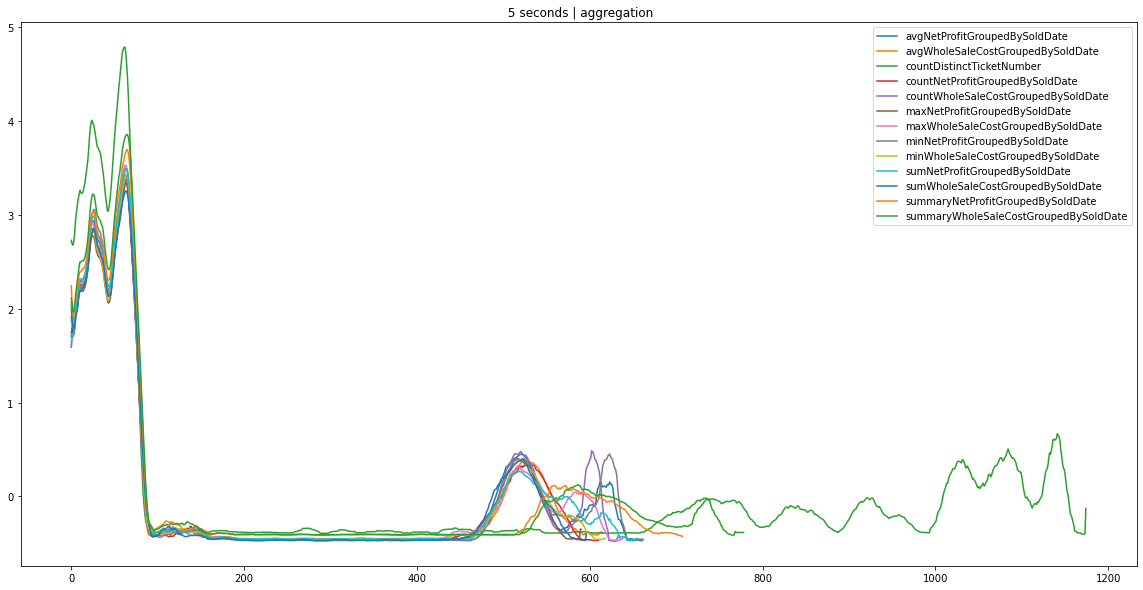

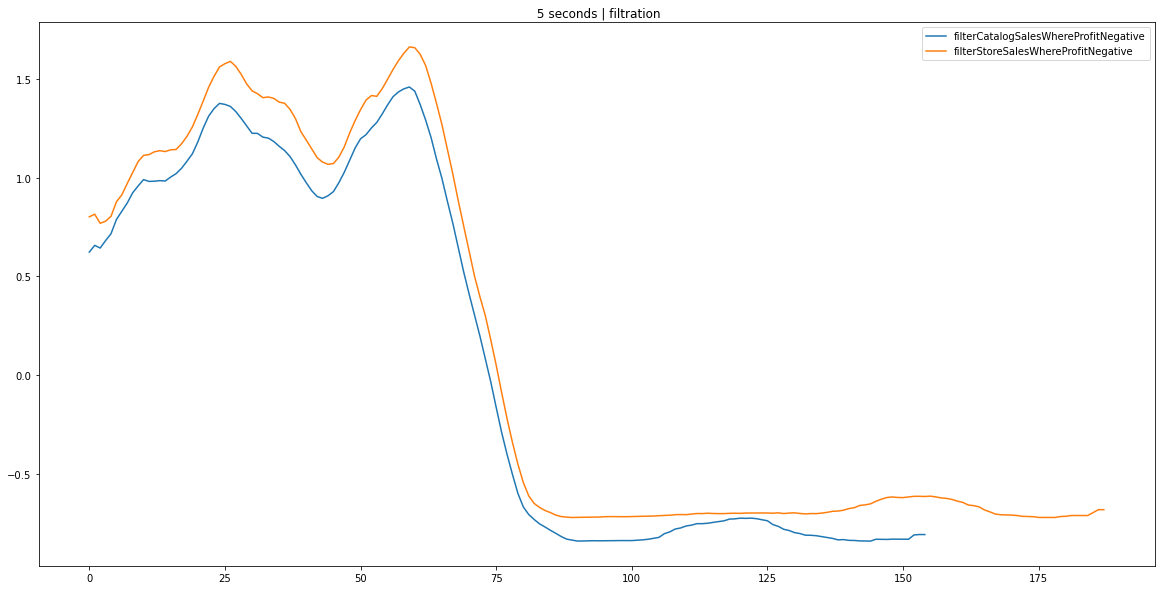

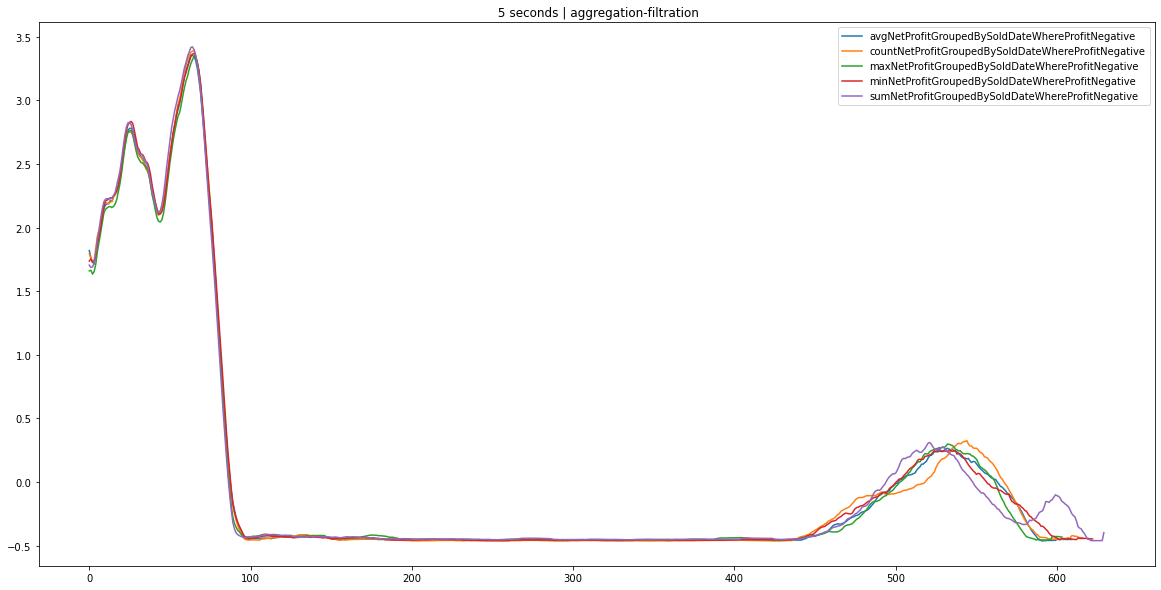

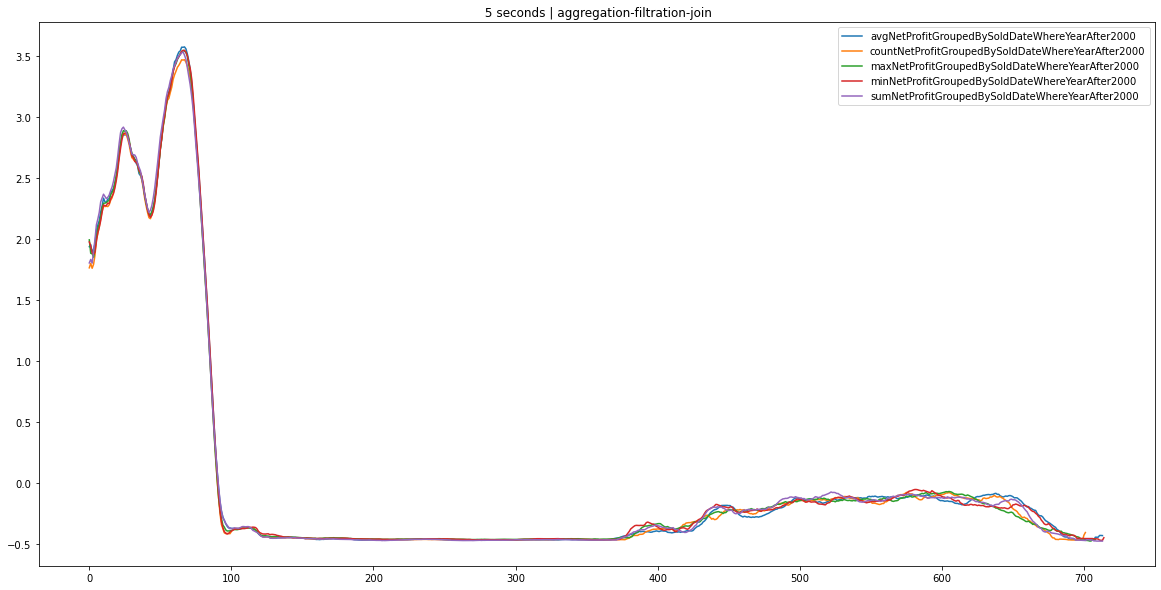

In [42]:
# agg_labeled agg_fil_labeled fil_labeled agg_fil_join_labeled
plot_udf_type(agg_labeled, "aggregation")
plot_udf_type(fil_labeled, "filtration")
plot_udf_type(agg_fil_labeled, "aggregation-filtration")
plot_udf_type(agg_fil_join_labeled, "aggregation-filtration-join")

